In [63]:
import os
import time
import torch
import torch_neuron
import json
import numpy as np
from urllib import request
from torchvision import models, transforms, datasets

from time import time
from IPython.display import display

In [64]:
IMAGES_DIR = 'images'
TEST_IMAGE = 'kitten_small.jpg'
CLASSES_FILE = 'imagenet_class_index.json'

test_image_path = f'{IMAGES_DIR}/{TEST_IMAGE}'

In [71]:
!ls -la $IMAGES_DIR
!ls -la $CLASSES_FILE

total 16
drwxrwxr-x  2 ubuntu ubuntu 4096 Jan 29 12:08 .
drwxrwxr-x 10 ubuntu ubuntu 4096 Jan 29 12:54 ..
-rw-rw-r--  1 ubuntu ubuntu 7341 Jan 29 10:50 kitten_small.jpg
-rw-rw-r-- 1 ubuntu ubuntu 35363 Jan 29 10:50 imagenet_class_index.json


In [65]:
idx2label = []

with open("imagenet_class_index.json", "r") as read_file:
 class_idx = json.load(read_file)
 idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

# Use the first image in the images applying transforms explicitly (outside the dataset loader) to simplify displaying
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])

trans = transforms.Compose([
            transforms.Resize([224, 224]),
            transforms.ToTensor(),
            normalize])
eval_dataset = datasets.ImageFolder(
    os.path.dirname('./'))
#     trans)
image, _ = eval_dataset[0]


image_tensor = trans(image)
image_tensor = torch.tensor(image_tensor.numpy()[np.newaxis, ...])

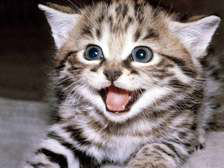

In [66]:
display(image)

In [68]:
# Original model first
orig_model = models.resnet50(pretrained=True)
orig_model.eval()
orig_results = orig_model(image_tensor)
orig_top5_idx = orig_results[0].sort()[1][-5:]

# Lookup and print the top 5 labels
orig_top5_labels = [idx2label[idx] for idx in orig_top5_idx]
print("Original model:\n-top 5 labels:\n {}".format(orig_top5_labels))

# Time it
start = time()
loops = 100
for _ in range(loops):
    orig_results = orig_model(image_tensor)
orig_elapsed_time = time() - start
orig_images_sec = loops / float(orig_elapsed_time)

print("Original {} operations in {} seconds => {} images / second".format(
    loops, 
    round(orig_elapsed_time,2), 
    round(orig_images_sec,0)))

Original model:
-top 5 labels:
 ['tiger', 'lynx', 'tiger_cat', 'Egyptian_cat', 'tabby']
Original 100 operations in 4.37 seconds => 23.0 images / second


In [70]:
# Load the compiled model
model_neuron = torch.jit.load('compiled/resnet50_neuron.pt')

# Run inference once before timing, will also help avoid skewing the timing
results = model_neuron(image_tensor)
top5_idx = results[0].sort()[1][-5:]
top5_labels = [idx2label[idx] for idx in top5_idx]
print("Compiled model:\n-top 5 labels:\n {}".format(top5_labels))

## Get an average inference time
start = time()
loops = 100
for _ in range(loops):
    results = model_neuron(image_tensor)
elapsed_time = time() - start
images_sec = loops / float(elapsed_time)

print("Completed {} operations in {} seconds => {} images / second".format(
    loops, 
    round(elapsed_time,2), 
    round(images_sec,0)))

Compiled model:
-top 5 labels:
 ['tiger', 'lynx', 'tiger_cat', 'Egyptian_cat', 'tabby']
Completed 100 operations in 0.35 seconds => 284.0 images / second
